In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.statespace.sarimax import SARIMAX


%matplotlib inline 

In [2]:
#SETTING THE DATASET READY
data = pd.read_csv('../Battle-sensors/FINAL.csv', sep=',', index_col=0, parse_dates = ["record_date"])# nrows=200000,

C:\Users\andyc\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
features = ["record_date", "loc_id", "desc", "temperature"]

df = pd.DataFrame(data, columns=features)
df = df.dropna()
df.set_index('record_date', inplace=True)
df = df.sort_index()
df.index = pd.to_datetime(df.index, utc=True)

#Getting unique local_ids and their counts
df.loc_id.value_counts()

16    41931
10    30931
13    28565
17    28516
24    26346
25    26340
22    26322
21    25848
26    25475
27    22221
28    21567
14    21144
11    20747
29    20299
23    18489
31    14996
33    12756
36    12567
12    10996
34     9700
32     8860
30     7683
35     4627
37     3055
Name: loc_id, dtype: int64

In [4]:
# Filter temperature readings between the given values
df = df.loc[(df.temperature > -25) & (df.temperature < 40)]

In [20]:
#Creating new data sets based on loc_id of censor
CS = df[(df.loc_id == 17)]
VB = df[(df.loc_id == 14)]
MH = df[(df.loc_id == 10)]


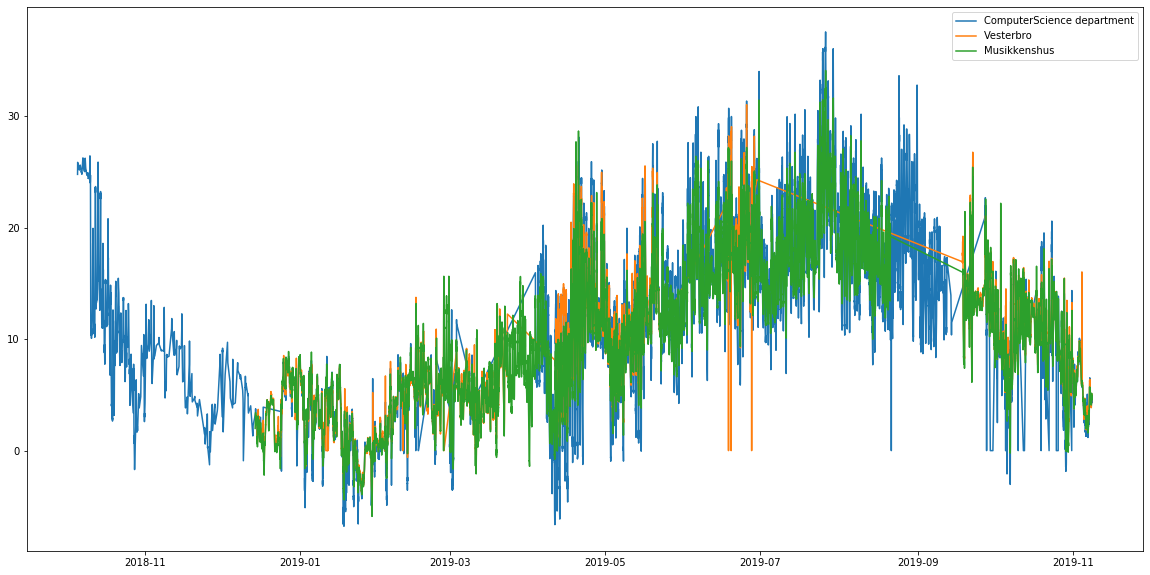

In [21]:
#Plotting times series by censor location
plt.figure(figsize=(20,10))

plt.plot(CS.temperature, label='ComputerScience department')
plt.plot(VB.temperature, label='Vesterbro')
plt.plot(MH.temperature, label='Musikkenshus')

plt.legend(loc='best', frameon=True) #loc='best' => legend location
plt.show()

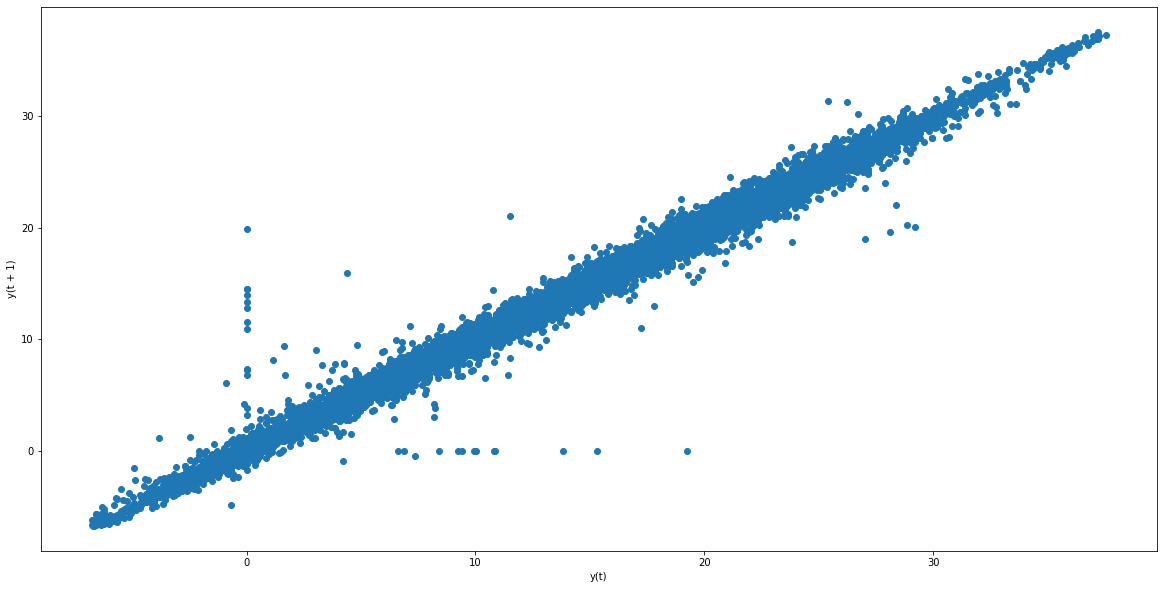

In [23]:
# assumption of dependance / correlation for autoregression
#compare your time series with a lagged time series, 
#in other words you shift the time series by 1 before comparing it with itself. 
pd.plotting.lag_plot(CS.temperature)

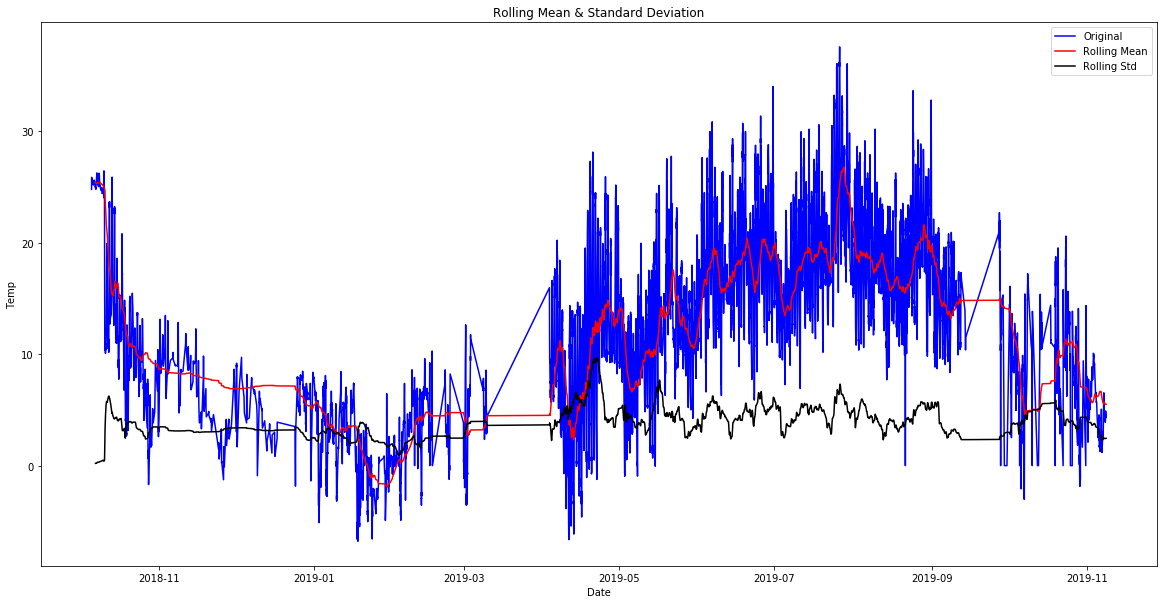

In [24]:
    
def generateStdRolMeanPlot(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=365,center=False).mean() #window can be 12 <=> months, 365 <=> days, 52 <=> weeks
    rolstd = timeseries.rolling(window=365,center=False).std()

    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.xlabel('Date')
    plt.ylabel('Temp')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
generateStdRolMeanPlot(CS.temperature)

# # TESTING STATIONARITY

--- Augumented dickey-fuller test ---

Null Hypothesis: The series has a unit root (value of a =1)(Series is none-stationary)

Alternate Hypothesis: The series has no unit root.

If the test statistic is less than the critical value, we can reject the null hypothesis (aka the series is stationary). When the test statistic is greater than the critical value, we fail to reject the null hypothesis (which means the series is not stationary).


In [25]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

def test_stationarity(timeseries):
      
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
#p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
#p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
test_stationarity(CS.temperature)

Results of Dickey-Fuller Test:
Test Statistic                -9.864746e+00
p-value                        4.142594e-17
#Lags Used                     4.900000e+01
Number of Observations Used    2.704100e+04
Critical Value (1%)           -3.430592e+00
Critical Value (5%)           -2.861647e+00
Critical Value (10%)          -2.566827e+00
dtype: float64


# KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test

KPSS is also a mirror of ADF.

Null Hypothesis: The process is trend stationary.

Alternate Hypothesis: The series has a unit root (series is not stationary).

If the test statistic is greater than the critical value (then the null hypothesis is rejected; the series is non-stationary.

In [26]:
#define function for kpss test
from statsmodels.tsa.stattools import kpss

#define KPSS
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
      kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)


kpss_test(CS.temperature)

Results of KPSS Test:
Test Statistic           10.72073
p-value                   0.01000
Lags Used                49.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


C:\Users\andyc\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1707: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [27]:
#Training the data
percent_training = 0.70
split_point = round(len(CS) * percent_training)
training, testing = CS[0:split_point], CS[split_point:]

# Applying differencing

In this method, we compute the difference of consecutive terms in the series. 

Differencing is typically performed to get rid of the varying mean. 

Mathematically, differencing can be written as: yt‘ = yt – y(t-1) where yt is the value at a time t

C:\Users\andyc\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


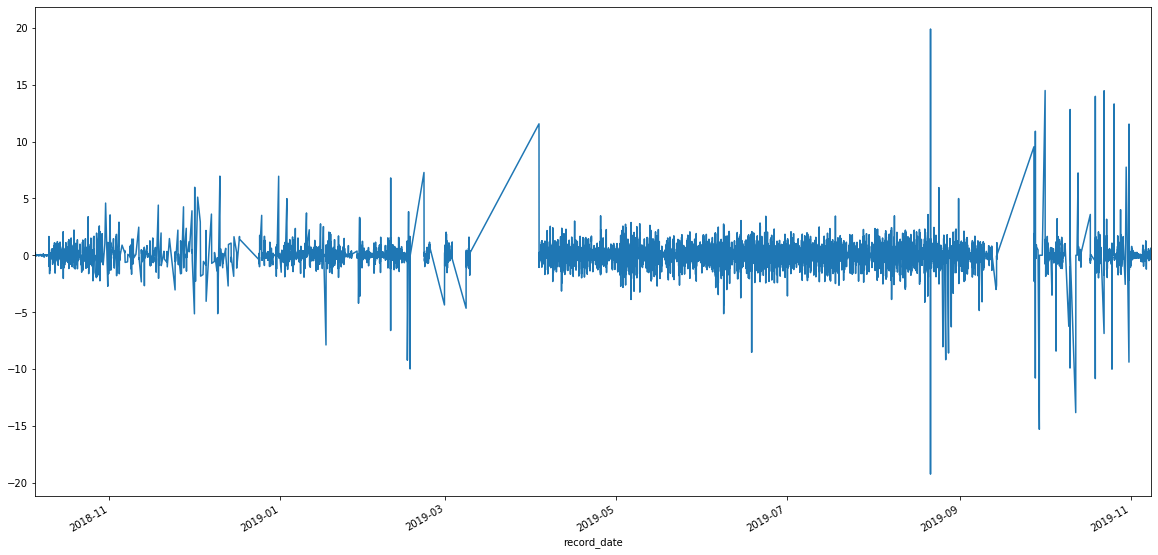

In [28]:
CS.temperature_diff = CS.temperature - CS.temperature.shift(1)
CS.temperature_diff.dropna().plot()

In [29]:
n=12 #12 months
CS.temperature_diff = CS.temperature- CS.temperature.shift(n)

C:\Users\andyc\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.
C:\Users\andyc\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.
C:\Users\andyc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


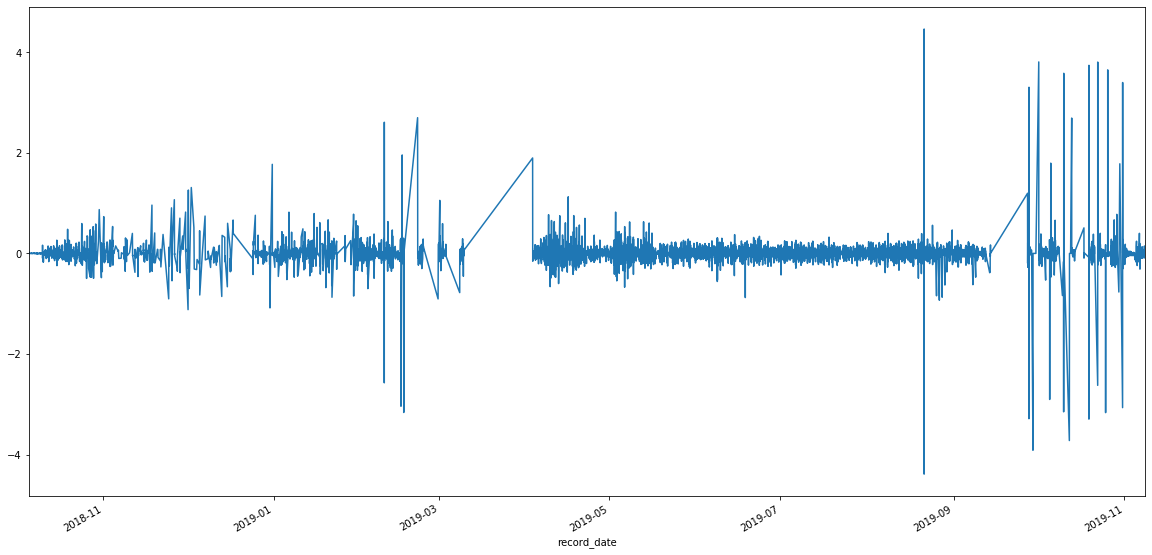

In [30]:
CS.temperature_sqrt = np.sqrt(CS.temperature)
CS.temperature_sqrt_diff = CS.temperature_sqrt - CS.temperature_sqrt.shift(1)
CS.temperature_sqrt_diff.dropna().plot()

In [31]:
CS.temperature_diff.dropna(inplace=True)

# ACF & PACF

plt.subplot takes three arguments: the number of rows (nrows), the number of columns (ncols) the plot number.

subplot(nrows, ncols, plot_number) Where nrows and ncols are used to notionally split the figure into nrows * ncols sub-axes, and plot_number is used to identify the particular subplot that this function is to create within the notional grid. plot_number starts at 1, increments across rows first and has a maximum of nrows * ncols.

In the case when nrows, ncols and plot_number are all < 10, a convenience exists, such that the a 3 digit number can be given instead, where the hundreds represent nrows, the tens represent ncols and the units represent plot_number. For instance:

subplot(211) produces a subaxes in a figure which represents the top plot (i.e. the first) in a 2 row by 1 column notional grid (no grid actually exists, but conceptually this is how the returned subplot has been positioned).

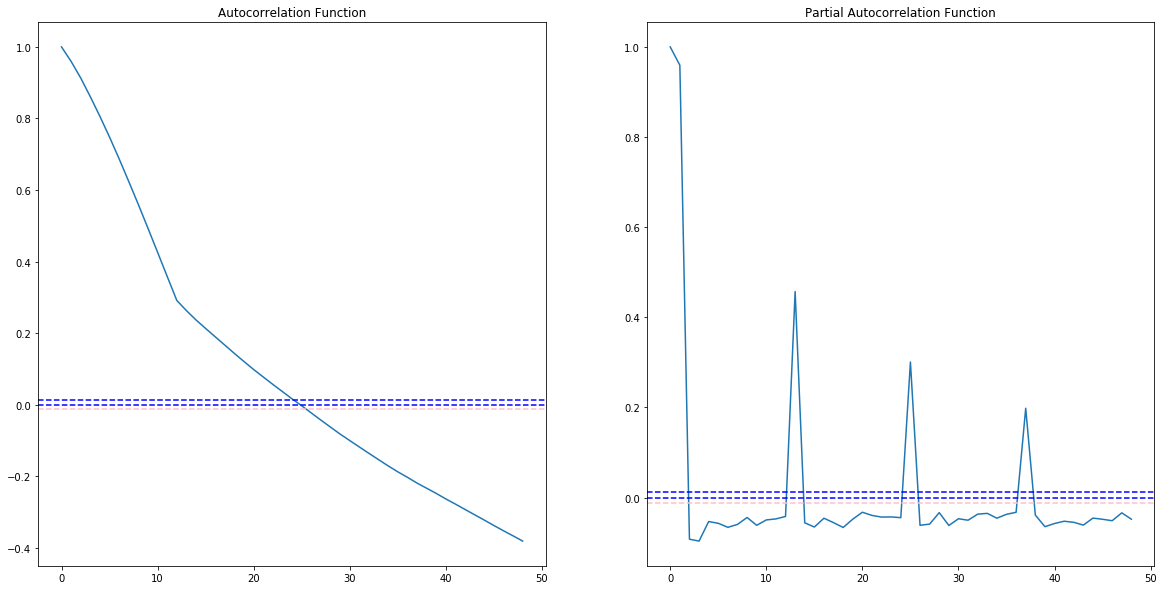

In [32]:
from statsmodels.tsa.stattools import acf,pacf

lag_acf = acf(CS.temperature_diff ,nlags=48)
lag_pacf = pacf(CS.temperature_diff ,nlags=48,method='ols')

######################### ACF ##########################################

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(CS.temperature_diff )),linestyle='--',color='pink')
plt.axhline(y=1.96/np.sqrt(len(CS.temperature_diff )),linestyle='--',color='blue')
plt.title('Autocorrelation Function')


######################### PACF ##########################################

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(CS.temperature_diff )),linestyle='--',color='pink')
plt.axhline(y=1.96/np.sqrt(len(CS.temperature_diff )),linestyle='--',color='blue')
plt.title('Partial Autocorrelation Function')
plt.show()

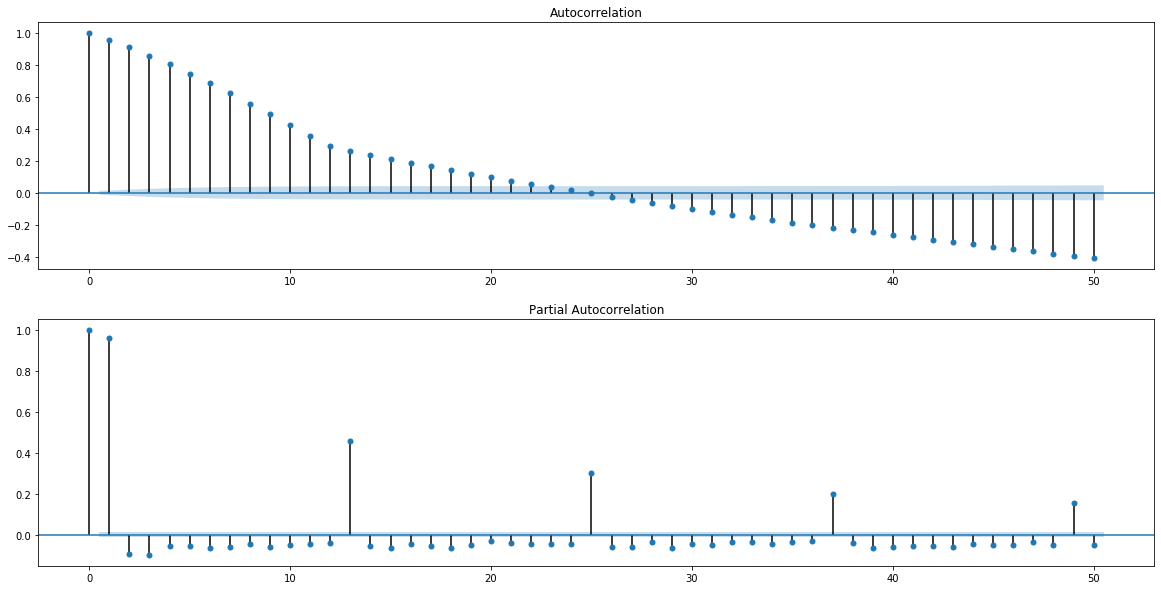

In [33]:
#Different plotting for ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.figure()
pyplot.subplot(211)
plot_acf(CS.temperature_diff, ax=pyplot.gca(), lags = 50)
pyplot.subplot(212)
plot_pacf(CS.temperature_diff, ax=pyplot.gca(), lags = 50)
pyplot.show()

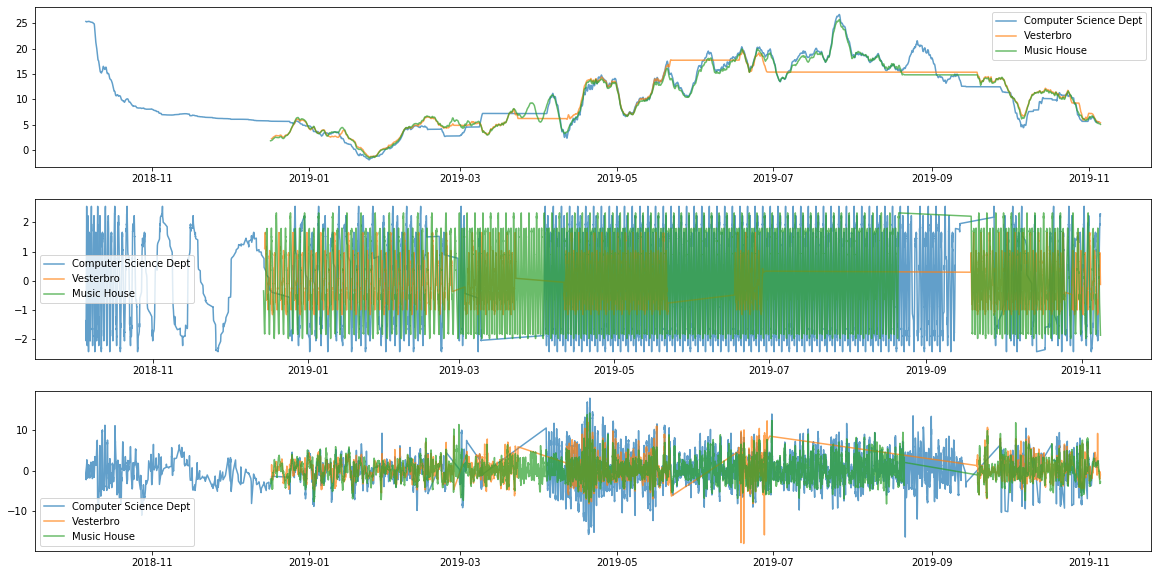

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose as sd

sd_CS = sd(CS.temperature, freq=365)
sd_VB = sd(VB.temperature, freq=365)
sd_MH = sd(MH.temperature, freq=365)

_=plt.figure(figsize=(20,10))

ax1=plt.subplot(311)
_=ax1.plot(sd_CS.trend, label='Computer Science Dept', alpha=0.7)
_=ax1.plot(sd_VB.trend, label='Vesterbro', alpha=0.7)
_=ax1.plot(sd_MH.trend, label='Music House', alpha=0.7)
_=plt.legend()

ax2=plt.subplot(312)
_=ax2.plot(sd_CS.seasonal, label='Computer Science Dept', alpha=0.7)
_=ax2.plot(sd_VB.seasonal, label='Vesterbro', alpha=0.7)
_=ax2.plot(sd_MH.seasonal, label='Music House', alpha=0.7)
_=plt.legend()


#Residual In regression analysis, the difference between the observed value of the dependent variable (y) and 
#the predicted value (ŷ) is called the residual (e). Each data point has one residual.
#Residual = Observed value - Predicted value e = y - ŷ
#Both the sum and the mean of the residuals are equal to zero. That is, Σ e = 0 and e = 0.

ax3=plt.subplot(313)
_=ax3.plot(sd_CS.resid, label='Computer Science Dept', alpha=0.7)
_=ax3.plot(sd_VB.resid, label='Vesterbro', alpha=0.7)
_=ax3.plot(sd_MH.resid, label='Music House', alpha=0.7)
_=plt.legend()

Each models have parameters:

ARMA model:(p,q) ARIMA model:(p,d,q) SARIMA model:(p,d,q)(sp,sd,sq,s) ARIMAX model:(p,d,q) + exog SARIMAX model:(p,d,q)(sp,sd,sq,s) +exog Model choice We have to choice a model, After we comfirm that a data has a trend(is stationary) or not. For example, ARMA model is premised that the data is stationary.

We can use ADF-test to check stationary of the data.

In [35]:
model = SARIMAX(CS.temperature_diff, order=(4,1,4), seasonal_order=(1,0,0,12), enforce_stationarity=False, enfroce_invertibility=False)
model_fit = model.fit(disp=False)

C:\Users\andyc\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\andyc\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\andyc\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
K = len(CS.temperature_diff)
forecast = model_fit.forecast(K)
forecast = np.exp(forecast)

plt.figure(figsize=(20,10))
plt.plot(forecast, 'r')
plt.plot(CS.temperature, 'b')

#Root Mean Square Error (RMSE) measures how much error there is between two data sets.
plt.title('RMSE: %.2f'% np.sqrt(sum((forecast-testing)**2)/len(CS.temperature_diff)))
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.autoscale(enable=True, axis='x', tight=True)
plt.axvline(x=CS.index[split_point], color='black');